# Trabajo Práctico 2 : Críticas cinematográficas N3

# Grupo: GPWin - N° 16

Integrantes:

- DIEM, Walter Gabriel

- MAIOLO, Alejandro

## Resumen

En esta notebook se explora el uso del modelo KNN con el vectorizer (count vectorizer más tfidf transformer)

## Preprocesamiento

Preparación de librerías

In [2]:
#%pip install joblib optuna

In [3]:
import pandas as pd
import numpy as np
import tensorflow as tf
import joblib
import matplotlib.pyplot as plt
import seaborn as sns
import re
import optuna

from sklearn.pipeline import Pipeline
from sklearn.metrics import precision_score, recall_score, accuracy_score,f1_score
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)

Seteo de semillas para mejor reproducción de resultados

In [4]:
np.random.seed(1)
tf.random.set_seed(1)

### Prepocesamiento de datos

Exploramos el dataset de train y test

In [5]:
critics = pd.read_csv("./datasets/train.csv")
critics.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   ID           50000 non-null  int64 
 1   review_es    50000 non-null  object
 2   sentimiento  50000 non-null  object
dtypes: int64(1), object(2)
memory usage: 1.1+ MB


In [6]:
criticsTest = pd.read_csv("./datasets/test.csv")
criticsTest.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8599 entries, 0 to 8598
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   ID         8599 non-null   int64 
 1   review_es  8599 non-null   object
dtypes: int64(1), object(1)
memory usage: 134.5+ KB


Tenemos 50k críticas para train y 8.6k entradas para test en Kaggle. Imprimimos una muestra para ver cómo son.

In [7]:
for critic in critics.sample(20)["review_es"]:
    print("###---###")
    print(critic)

###---###
Sin héroes muertos, se obtienen líneas estúpidas como esa, ya que se debe ver esta película de acción lamentablemente abismal. William Sanders es salvada por su amigo Harry Cotter durante una extracción en Vietnam, pero el enemigo capturado por el enemigo. Avance rápido de diez años y Harry ahora es un operario ruso en lavado de cerebro con un microchip de control mental implantado en su cerebro. Su nuevo Superior Ruso es Ivan jugó a la empuñadura obscena por Nick Nicholson, quien podría agregar no solo no intenta hablar con un acento ruso, sino que se parece a más un asistente de gasolina en Kentucky con sus dientes manchados. Lo que es aún más absurdo es el hecho de que también fue el entrenador de diálogo para esta película. Pronto William es re-reclutado por la CIA para cazar a Harry. Se adapta a Barbara, un luchador por la libertad que ha infiltrado el campamento de El Salvador de Ivan y pronto los dos están soplando la mitad de América del Sur. Algunas escenas son tan h

Cambiamos el nombre de la columna `review_es` a sólo `review`

In [8]:
critics.rename(columns={"review_es": "review"}, inplace=True)
critics.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   ID           50000 non-null  int64 
 1   review       50000 non-null  object
 2   sentimiento  50000 non-null  object
dtypes: int64(1), object(2)
memory usage: 1.1+ MB


Revisamos valores nulos

In [9]:
criticsNull = critics.isnull().any()
criticsNull

ID             False
review         False
sentimiento    False
dtype: bool

No hay valores nulos en el dataset. Revisamos el balance entre reviews negativas y positivas 

In [10]:
critics["sentimiento"].value_counts()

positivo    25000
negativo    25000
Name: sentimiento, dtype: int64

Hay la misma cantidad de reviews positivas y negativas

Hacemos una función que a cada review le pasará a minúscula las palabras que no estén completamente escritas es mayúsculas

In [11]:
def toLowercaseIfNotFullyUppercase(review):
    words = review.split()
    parsedReview = []

    for word in words:
        if word.isupper():
            parsedReview.append(word)
        else:
            parsedReview.append(word.lower())

    return ' '.join(parsedReview)

In [12]:
critics["review"].apply(toLowercaseIfNotFullyUppercase)

0        uno de los otros críticos ha mencionado que de...
1        una pequeña pequeña producción.la técnica de f...
2        pensé que esta era una manera maravillosa de p...
3        básicamente, hay una familia donde un niño peq...
4        el "amor en el tiempo" de petter mattei es una...
                               ...                        
49995    pensé que esta película hizo un buen trabajo a...
49996    mala parcela, mal diálogo, mala actuación, dir...
49997    soy católica enseñada en escuelas primarias pa...
49998    voy a tener que estar en desacuerdo con el com...
49999    nadie espera que las películas de star trek se...
Name: review, Length: 50000, dtype: object

Encodeamos con LabelEncoder a los sentimientos

In [13]:
labelEncoder = LabelEncoder()
labelEncoder.fit(critics["sentimiento"])

print("Encoding queda:")
print(f"0 = {labelEncoder.inverse_transform([0])[0]}\n1 = {labelEncoder.inverse_transform([1])[0]}")

Encoding queda:
0 = negativo
1 = positivo


In [14]:
critics["sentimiento"] = labelEncoder.transform(critics["sentimiento"])
critics["sentimiento"].sample(4)

45997    0
9976     1
48042    0
3714     0
Name: sentimiento, dtype: int32

Creamos una función que remueva caracteres que no sean una palabra con espacios y los cambiamos por un espacio

In [15]:
def removePunctuation(review):
    return re.sub(r'[^\w\s]', ' ', review)

In [16]:
critics["review"] = critics["review"].apply(removePunctuation)
critics["review"].sample(10)

20895    El único bien  ya sea de los problemas  las pe...
35913    Si bien esto está horriblemente anticuado  deb...
29522    Mark Frechette Estrella como Mark  una univers...
8761     Si es cierto que el sadomasoquismo es una mone...
49943     SIR  ha jugado a LEAR más de 200 veces  pero ...
851      Steven Seagal s films of late have not exactly...
31578     Paso  Hanna Barbera de los años 60 y 70   Qué...
33833    Desde los primeros 10 segundos de tono de negr...
22722    Esta es la peor película absoluta que he visto...
23456    Después de haber visto al cazador de ciervos  ...
Name: review, dtype: object

### Split

Hacemos el split de train y test con relación de ~1/6

In [17]:
critics_x = critics["review"].copy()
critics_y = critics["sentimiento"].copy()

x_train, x_test, y_train, y_test = train_test_split(critics_x,
                                                    critics_y,
                                                    test_size=0.18,
                                                    random_state=0)

### Procesamos conjunto de test de Kaggle

Con el dataset que submitearemos a Kaggle, lo importamos y la hacemos los mismos cambios que se le hicieron al conjunto de training

In [18]:
criticsTest = pd.read_csv("./datasets/test.csv")
criticsTest.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8599 entries, 0 to 8598
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   ID         8599 non-null   int64 
 1   review_es  8599 non-null   object
dtypes: int64(1), object(1)
memory usage: 134.5+ KB


Le cambiamos el nombre a la columna review

In [19]:
criticsTest.rename(columns={"review_es": "review"}, inplace=True)
criticsTest.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8599 entries, 0 to 8598
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   ID      8599 non-null   int64 
 1   review  8599 non-null   object
dtypes: int64(1), object(1)
memory usage: 134.5+ KB


Procesamos las mayúsculas y minúsculas

In [20]:
criticsTest["review"].apply(toLowercaseIfNotFullyUppercase)

0       la mayor virtud de esta película es su existen...
1       no soy un experto cinéfilo, pero pocas veces m...
2       si no eres un incondicional del humor estilo t...
3       no sé qué está pasando, si la gente se deja ll...
4       pero cuando amanece,y me quedo solo,siento en ...
                              ...                        
8594    buena no, lo siguiente. por fin un film serio ...
8595    me esperaba mucho, pero que mucho, más.guión m...
8596    de mal cuerpo como sensación al finalizar, de ...
8597    los que han añadido comentarios os lo han dich...
8598    fui a ver esta película de cine con entusiasmo...
Name: review, Length: 8599, dtype: object

Procesamos los signos de puntación

In [21]:
criticsTest["review"] = criticsTest["review"].apply(removePunctuation)
criticsTest["review"].sample(10)

7494    Hace ya algún tiempo que se estreno este éxito...
8078    Comedia española con claras intenciones amable...
82      Sobrevalorada comedía que no ofrece nada nuevo...
187     La película más taquillera de la historia del ...
3495    Aviso a vuesas mercedes Acaba de estrenarse Al...
2108    En un principio puede parecer incluso interesa...
4271    Celda 211 es una película sobrevalorada  Tiene...
8168    Cuando una película funciona y no hay ideas y ...
6135    De las peores películas que he visto en los ul...
6290    Yo creo que si el señor Amenábar estuviera en ...
Name: review, dtype: object

## Modelo KNN con optimización de hiperparámetros

Para el entrenamiento del modelo KNN usaremos como tokenizador al count vectorizer más el tfidf transformer. La optimización se hará de manera bayesiana igual que en los notebooks anteriores.

Los parámetros a optimizar del KNN serán:
- weights: función de peso al realizar las predicciones
- n_neighbors: cantidad de vecinos que se tengan en cuenta

Creamos la función objetivo que vamos a optimizar

In [23]:
runNumber=10

def objective(trial):

    parametersVectorizer = {
        'strip_accents': trial.suggest_categorical('strip_accents', ['ascii', 'unicode', None]),
        'lowercase': trial.suggest_categorical('lowercase', [True, False]),
        'ngram_range': trial.suggest_categorical('ngram_range', [(1,1), (1,2), (2,2)]),
        'binary': trial.suggest_categorical('binary', [True, False]),
        'analyzer': 'word'
    }

    parametersTransformer = {
        'norm': trial.suggest_categorical('norm', ['l1', 'l2', None]),
        'use_idf': trial.suggest_categorical('use_idf', [True, False]),
        'sublinear_tf': trial.suggest_categorical('sublinear_tf', [True, False]),
    }

    parametersModel = {
          'weights': trial.suggest_categorical('weights', ['uniform', 'distance']),
          'n_neighbors': trial.suggest_int('n_neighbors', 1, 20),
          'n_jobs': -1
         
    }

    KNNPipeline = Pipeline(steps=[
        ('vectorizer', CountVectorizer(**parametersVectorizer)),
        ('tfidfTransformer', TfidfTransformer(**parametersTransformer)),
        ('KnnClassifier', KNeighborsClassifier(**parametersModel))
    ])

    KNNPipeline.fit(x_train, y_train)
    y_pred = KNNPipeline.predict(x_test)

    return f1_score(y_test, y_pred, average='binary')

Creamos un study que va a ser donde corramos el "estudio de maximizar la función objetivo" definida arriba (que optimiza el f1 score)

In [24]:
study = optuna.create_study(direction='maximize')

[I 2023-11-26 15:27:12,283] A new study created in memory with name: no-name-6093cb51-23a8-4cd8-9d87-769f245bbd70


El método de sampleo de hiperparámetros que seguirá la optimización bayesiana será con el tree-structured Parzen estimators -TPE

In [25]:
study.sampler.__class__.__name__

'TPESampler'

Ejecutamos el estudio

In [ ]:
study.optimize(objective, n_trials=10, n_jobs=3)

Las 10 iteraciones tardaron 4.5 horas

Seleccionamos el mejor trial (intento) con el mejor score y el mejor conjunto de hiperparámetros

In [153]:
bestTrial = study.best_trial
bestScore = bestTrial.value
hyperparameters = bestTrial.params

print('Cantidad de trials total: {}'.format(len(study.trials)))
print('Mejor f1score: ' + str(bestScore) + "\n")

for param, value in hyperparameters.items():
    print(f"{param}: {value}")

Cantidad de trials total: 10
Mejor f1score: 0.8384857359800412

strip_accents: unicode
lowercase: False
ngram_range: (2, 2)
binary: True
norm: l2
use_idf: True
sublinear_tf: False
weights: distance
n_neighbors: 19


Recreamos una pipeline con estos mejores parámetros

In [154]:
parametersVectorizer = {
    'strip_accents': hyperparameters["strip_accents"],
    'lowercase': hyperparameters["lowercase"],
    'ngram_range': hyperparameters["ngram_range"],
    'binary': hyperparameters["binary"],
    'analyzer': 'word'
}

parametersTransformer = {
    'norm': hyperparameters["norm"],
    'use_idf': hyperparameters["use_idf"],
    'sublinear_tf': hyperparameters["sublinear_tf"],
}

parametersModel = {
    'weights': hyperparameters["weights"],
    'n_neighbors': hyperparameters["n_neighbors"],
    'n_jobs': -1
}

KNNPipeline = Pipeline(steps=[
        ('vectorizer', CountVectorizer(**parametersVectorizer)),
        ('tfidfTransformer', TfidfTransformer(**parametersTransformer)),
        ('KnnClassifier', KNeighborsClassifier(**parametersModel))
])

KNNPipeline.fit(x_train, y_train)

Pipeline(steps=[('vectorizer',
                 CountVectorizer(binary=True, lowercase=False,
                                 ngram_range=(2, 2), strip_accents='unicode')),
                ('tfidfTransformer', TfidfTransformer()),
                ('KnnClassifier',
                 KNeighborsClassifier(n_jobs=-1, n_neighbors=19,
                                      weights='distance'))])

Parámetros de toda la pipeline

In [155]:
KNNPipeline.get_params()

{'memory': None,
 'steps': [('vectorizer',
   CountVectorizer(binary=True, lowercase=False, ngram_range=(2, 2),
                   strip_accents='unicode')),
  ('tfidfTransformer', TfidfTransformer()),
  ('KnnClassifier',
   KNeighborsClassifier(n_jobs=-1, n_neighbors=19, weights='distance'))],
 'verbose': False,
 'vectorizer': CountVectorizer(binary=True, lowercase=False, ngram_range=(2, 2),
                 strip_accents='unicode'),
 'tfidfTransformer': TfidfTransformer(),
 'KnnClassifier': KNeighborsClassifier(n_jobs=-1, n_neighbors=19, weights='distance'),
 'vectorizer__analyzer': 'word',
 'vectorizer__binary': True,
 'vectorizer__decode_error': 'strict',
 'vectorizer__dtype': numpy.int64,
 'vectorizer__encoding': 'utf-8',
 'vectorizer__input': 'content',
 'vectorizer__lowercase': False,
 'vectorizer__max_df': 1.0,
 'vectorizer__max_features': None,
 'vectorizer__min_df': 1,
 'vectorizer__ngram_range': (2, 2),
 'vectorizer__preprocessor': None,
 'vectorizer__stop_words': None,
 've

Esta es la misma predicción de test que se realizó durante el estudio

In [23]:
y_pred = KNNPipeline.predict(x_test)

Imprimimos la matriz de confusión. Se agrega una caja de texto con las equivalencias entre las etiquetas numéricas y el sentimiento

F1-Score: 0.8384857359800412


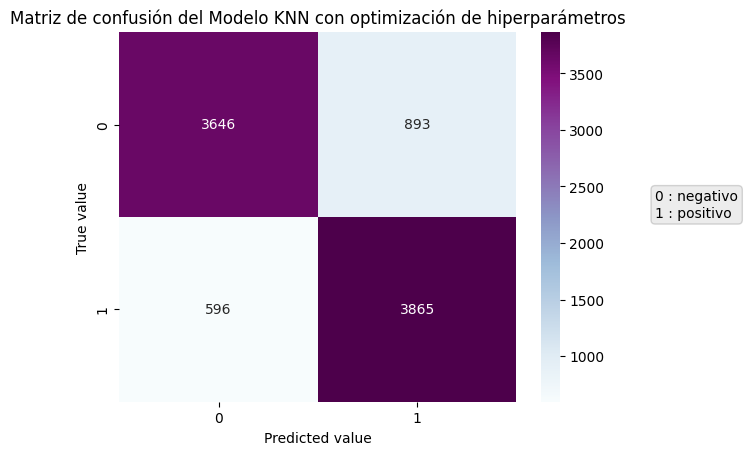

In [25]:
print('F1-Score: {}'.format(f1_score(y_test, y_pred, average='binary')))

confussionMatrix = confusion_matrix(y_true=y_test, y_pred=y_pred)
sns.heatmap(confussionMatrix,cmap='BuPu', annot=True, fmt='g')
plt.xlabel('Predicted value')
plt.ylabel('True value')
plt.title("Matriz de confusión del Modelo KNN con optimización de hiperparámetros")
plt.text(2.7, 1, f"0 : {labelEncoder.inverse_transform([0])[0]}\n1 : {labelEncoder.inverse_transform([1])[0]}", bbox=dict(boxstyle='round', facecolor='grey', alpha=0.15))
plt.show()

Mostramos las distintas métricas

In [159]:
accuracy = accuracy_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)

print(f"Accuracy: {str(accuracy)}")
print(f"Recall: {str(recall)}")
print(f"Precision: {str(precision)}")
print(f"f1 score: {str(f1)}")

Accuracy: 0.8345555555555556
Recall: 0.8663976686841516
Precision: 0.8123160992013451
f1 score: 0.8384857359800412


Realizamos las predicciones de los datos que vamos a submitear a kaggle

In [160]:
y_pred = KNNPipeline.predict(criticsTest["review"])

Agrupamos en el dataframe los valores predichos decodeados con el label encoder

In [161]:
kaggleResult = criticsTest.copy()
kaggleResult.drop(columns=["review"], inplace=True)

kaggleResult["sentimiento"] = labelEncoder.inverse_transform(y_pred)

kaggleResult.head(2)

,ID,sentimiento
0,60000,negativo
1,60001,positivo


Para exportar a Kaggle exportamos el csv. El `runNumber` es sólo un número que ponemos para no pisar los submits

In [164]:
kaggleResult.to_csv(f"submit_{runNumber}_grupo16_gpwin_KNN.csv", index=False)

Guardamos una serialización del modelo

In [165]:
filename = f'./KNN_model_{runNumber}.joblib'
modelInfo = {'model': KNNPipeline}

joblib.dump(modelInfo, filename)

['./KNN_model_10.joblib']